In [565]:
import scipy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from datetime import datetime
from datetime import date
import statistics as st
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.distributions.empirical_distribution import ECDF
from TimeSerie_fct import create_monthly_avg_time_serie
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import calendar
import os


data_temperature = pd.read_table('../data/observatoire-geneve/TG_STAID000241.txt',sep = ',',
                                names = ['SOUID','DATE','TG','Q_TG'], skiprows = range(0,20))

data_temperature.drop(data_temperature[ data_temperature['Q_TG'] == 9 ].index, inplace = True)
data_temperature['Year'] = [int(str(d)[:4]) for d in data_temperature.DATE]
data_temperature['Month'] = [int(str(d)[4:6]) for d in data_temperature.DATE]
data_temperature['Day'] = [int(str(d)[6:8]) for d in data_temperature.DATE]

#Compute the day of the year for each year
day_of_year = np.array(len(data_temperature['Day']))

adate = [datetime.strptime(str(date),"%Y%m%d") for date in data_temperature.DATE]
data_temperature['Day_of_year'] = [d.timetuple().tm_yday for d in adate]
data_temperature.TG = data_temperature.TG/10.

In [22]:
df = data_temperature.copy()
plt.style.use("ggplot")

In [34]:
# Transformation en moyenne mesuelle
Years = df.Year.unique()
Months = df.Month.unique()
data_M = pd.DataFrame(np.array([[df[(df.Year == y)&(df.Month==m)].TG.mean(),
                        df[(df.Year == y)&(df.Month==m)].TG.median(),df[(df.Year == y)&(df.Month==m)].TG.std()
                                 ,y,int(m)] for y in Years for m in Months]),
                     columns=["Mean","Median","Std","Years","Month"])
data_M = data_M.dropna()
data_M["grid"] = np.array([y + float(m-1)/12 for y in Years for m in Months])[:np.shape(data_M)[0]]

In [24]:
data_M.to_csv("Monthly_Mean.csv",index=False)

In [576]:
fig,((ax1,ax2),(ax3,ax4),(ax5,ax6),(ax7,ax8),(ax9,ax10),(ax11,ax12)) = plt.subplots(6,2,figsize=(18,12))
axs = (ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11,ax12)
for m in Months:
    Y = data_M[data_M.Month == m].Years.unique()
    axs[m-1].plot(Y,data_M[data_M.Month==m].Mean, color = 'k')
    axs[m-1].set_title("Monthly mean temperature of "+calendar.month_name[int(m)]+" from 1901 to 2021")
    plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.8)

    axs[m-1].set_xlabel("Years")
    axs[m-1].set_ylabel("Temperature(°C)",fontsize=8)

plt.savefig("figure/Monthly/Monthly_mean_median_std.png", dpi=300, bbox_inches='tight')
plt.close(fig)

In [59]:
fig, ax = plt.subplots(1,1,figsize=(30,4), dpi= 300)
fig.suptitle("Monthly mean temperature",y = 1.,size='x-large',weight = 'roman')
plt.plot(data_M.grid,data_M.Mean)
ax.set(xlabel="Years",ylabel="Temperature(°C)")
plt.savefig("figure/Monthly_mean_TimeSeries.png", dpi=300, bbox_inches='tight')
plt.close(fig)

# Fit on all the time series

In [116]:
def ff(m,y,param):
    tg = 0
    for i in range(1,13):
        tg += (m==float(i))*param[i-1]
    tg += param[-1]*y
    return tg

In [153]:
def plot_ljung_pierce(data, loca = (0.82,0.7), semilog_y = True,fname ='figure/p_values_Ljung_Pierce_McLeod_test.png', closefig = False,alpha = 0.05,df=0):
    test_Q = sm.stats.acorr_ljungbox(data, lags=range(1,50), return_df=True,boxpierce=True,model_df = df)

    p_values_McLeod_Li = sm.stats.acorr_ljungbox(data**2, lags=range(1,50), return_df=True,model_df = df).lb_pvalue
    p_values_Pierce = test_Q.lb_pvalue
    p_values_Ljung = test_Q.bp_pvalue
    
    fig = plt.figure(figsize=(9,5), dpi=300, tight_layout = True)
    fig.suptitle("P-values of the Ljung-Box ,Box-Pierce and McLeod-Li Tests",y = 0.95
                 ,size='x-large',weight = 'roman')


    plt.plot(p_values_Pierce,'o-',markersize = 4,label='Box-Pierce')
    plt.plot(p_values_Ljung,'-o',markersize = 4,label='Ljung-Box')
    plt.plot(p_values_McLeod_Li,'-o',markersize = 4,label='McLeod-Li')
    
    if (semilog_y): plt.semilogy()
    plt.axhline(y=alpha,linestyle='--',label='p_value = '+str(alpha))
    fig.legend(loc = loca)
    plt.xlabel('Autocorrelation lags')
    plt.ylabel('p-values')

    plt.savefig(fname, dpi=300, bbox_inches='tight')
    if (closefig) : plt.close(fig)
    return 

In [186]:
def plot_acf_pacf(data,lag = 50,closefig=False,fname = "figure/Annual_acf_pacf_test.png",title = 'ACF and PACF'):
    fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 300)
    
    fig.suptitle(title,y = 1.1,size='x-large',weight = 'roman')
    
    plot_acf(data, lags=lag,ax=axes[0], color='k',zero = False,auto_ylims = True)
    plot_pacf(data, lags=lag,ax=axes[1], color='k',zero = False,auto_ylims = True,method = 'ywm')
    
    axes[0].set(xlabel="lags")
    axes[1].set(xlabel="lags")
    
    
    plt.savefig(fname, dpi=300, bbox_inches='tight')
    if (closefig): plt.close(fig)
    return

In [243]:
def qq_plot(data,fname = "figure/Annual_qqplot_test.png"):
    fig = qqplot(data,loc = data.mean(), scale = data.std(), line ='45')
    fig.suptitle("QQ-plot",y = 0.95,size='xx-large',weight = 'roman')
    plt.show()
    
    plt.savefig(fname, dpi=300, bbox_inches='tight')
    plt.close(fig)
    return

In [244]:
def ecdf_vs_cdf(data,fname ="figure/Annual_ecdf_cdf_test.png", closefig=False):
    ecdf = ECDF(data)
    mean = data.mean()
    std = data.std()
    x = np.linspace(-4.+mean,4.+mean,5000)
    
    fig, axs = plt.subplots(1,2, figsize=(14,4))
    
    axs[0].plot(x,ecdf(x),"k",label='ecdf')
    axs[0].plot(x,sc.stats.norm.cdf(x,loc = mean,scale = std), "b--", label = 'cdf')
    axs[1].plot(x,np.abs(ecdf(x)-sc.stats.norm.cdf(x,loc = mean ,scale = std)),color = 'k')
    
    axs[0].set(xlabel="x",ylabel="P (X<=x)")
    axs[1].set(xlabel="x",ylabel="Absolute deviation")
    axs[0].set_title("Ecdf vs cdf")
    axs[1].set_title("Absolute deviation of the ecdf from the cdf")
    
    axs[0].legend(loc = (0.05,0.8))
    
    plt.savefig(fname, dpi=300, bbox_inches='tight')
    if (closefig): plt.close(fig)
    return

## Modélisation  1

In [178]:
# Temeprature explain by the years and a intercept depending on the month
n = np.shape(data_M.Mean)[0]
t = np.array(data_M.Mean).reshape((n,1))
one = np.ones(shape=(np.shape(t)[0],1))
d = np.concatenate([np.array([(data_M.Month == float(i))]).reshape((n,1)) for i in np.arange(1,13)],axis = 1)
d2 = data_M.Years.copy()-1900

D2 = np.array(d2).reshape((n,1))
X = np.concatenate([d,D2],axis = 1)

acf_ = acf(data_M.Mean,nlags=n,fft=False)

sigma = data_M.Mean.var()*sc.linalg.toeplitz(acf_)
reg = sm.GLS(data_M.Mean,X,sigma).fit()
res = reg.resid
coef = reg.params

for i in range(5):
    acf_ = acf(res,nlags=n,fft=False)
    sigma = res.var()*sc.linalg.toeplitz(acf_)
    reg = sm.GLS(data_M.Mean,X,sigma).fit()
    res = reg.resid
    

In [185]:
summary1 = reg.summary()
g = open('txt/Monthly/summary1901-1962_GLS.txt','w')
g.write(summary1.as_latex())
g.close()
# F-stat big / good R-squared / positive conf. int. for the linear term in year (x13) 

In [180]:
#Plot entiere regression
fig = plt.figure(figsize=(25,5), dpi=300, tight_layout = True)
fig.suptitle("Modelisation of the trend and seasonality by GLS",y = 0.95,size='x-large',weight = 'roman')

plt.plot(data_M.grid,res,'grey')

plt.xlabel('Year')
plt.ylabel('Temperature (°C)')

plt.savefig('figure/Monthly/GLS1_res.png', dpi=300, bbox_inches='tight')
plt.close()

In [181]:
data_M["Mean_Seasonless"] = res

In [190]:
plot_acf_pacf(data_M.Mean_Seasonless,lag=50, title = 'ACF and PACF of monthly seasonless mean temperature'
              ,closefig=True,fname = 'figure/Monthly/Seasonless_mean_acf_pacf.png')
plot_ljung_pierce(data_M.Mean_Seasonless,semilog_y = True,loca = (0.78,0.66),closefig=True
                 ,fname = 'figure/Monthly/Seasonless_mean_Ljung_Pierce.png',df = 12)

#les plots acf et pacf ne permettent pas de rejetter l'hypothèse d'indépendance mais les tests de Ljung et Pierce 
#nous permettent de largement rejetter l'hypothèse d'indépendance.

In [237]:
#Stationarity test on seasonless mean with addfuller
test_addfuller = adfuller(data_M.Mean_Seasonless, maxlag=None, regression='n', autolag='AIC'
                          , store=False, regresults=True)

g = open('txt/Monthly/addfullerTest_monthly.txt','a')
g.write("Monthly Seasonless mean (no constant) (model 1) : p-value = "+str(test_addfuller[1])+'\n')
g.close()
# the p-value of the addfuller test let us think that the time series is stationary

In [203]:
#Model selection using AIC
p = np.array(np.arange(0,12))
q = np.array(np.arange(0,5))

param = np.array([np.array([int(pp),int(qq)]) for pp in p for qq in q])

AIC = np.zeros(shape=(np.shape(param)[0],))

model_selection = pd.DataFrame(np.array([param[:,0],param[:,1],AIC]).T, columns = ["param_p","param_q","AIC"])

for i, (pp,qq) in enumerate(param):
    arma_mod = ARIMA(data_M.Mean_Seasonless, order=(pp,0,qq)).fit(method = 'innovations_mle')
    model_selection.AIC[i] = arma_mod.aic

i = np.argmin(model_selection.AIC)
mod = model_selection.to_latex()

g = open('txt/Monthly/ModelSelection1_monthly.txt','w')
g.write(mod)
g.close()

/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima/estimators/gls.py:296: UserWarning: Feasible GLS failed to converge in 50 iterations. Consider increasing the maximum number of iterations using the `max_iter` argument or reducing the required tolerance using the `tolerance` argument.
  warnings.warn('Feasible GLS failed to converge in %d iterations.'


In [236]:
fig = plt.figure(figsize=(9,5), dpi=300, tight_layout = True)
fig.suptitle("Model selection for the seasonless mean",y = 1,size='x-large',weight = 'roman')

plt.plot(range(0,12),model_selection[model_selection.param_q == 0].AIC,'o-')
plt.plot(range(0,12),model_selection[model_selection.param_q == 1].AIC,'-o')
plt.plot(range(0,12),model_selection[model_selection.param_q == 2].AIC,'o-')
plt.plot(range(0,12),model_selection[model_selection.param_q == 3].AIC,'-o')
plt.plot(range(0,12),model_selection[model_selection.param_q == 4].AIC,'-o')

plt.xlabel('AR(p) parameters')
plt.ylabel('AIC')
qq = ['p=0','p=1','p=2','p=3','p=4','p=5','p=6','p=7','p=8','p=9','p=10','p=11',]
plt.xticks(range(0,12),qq)
fig.legend(['q=0','q=1','q=2','q=3','q=4'],loc = (0.88,0.7))

plt.savefig('figure/Monthly/seasonless_mean_model_selection_AIC', dpi=300, bbox_inches='tight')
plt.close()

In [229]:
#On fixe le modèle ARMA(4,3)
p = 4
q = 3
arma_mod = ARIMA(data_M.Mean_Seasonless, order=(p,0,q)).fit(method = 'innovations_mle')
res = arma_mod.resid

In [239]:
summary = arma_mod.summary()

g = open('txt/Monthly/ModelSelection_monthly.txt','w')
g.write(summary.as_latex())
g.close()

In [235]:
plot_acf_pacf(res,lag=50, title = 'ACF and PACF of the ARMA(4,3) residues'
              ,closefig=True,fname = 'figure/Monthly/Seasonless_mean_acf_pacf.png')
plot_ljung_pierce(res,semilog_y = False,loca = (0.78,0.66),closefig=True
                 ,fname = 'figure/Monthly/Detrended_mean_Ljung_Pierce.png',df = p+q)
#Nous ne pouvons plus rejetter l'hypothèse d'indépendance.

In [250]:
#Test de normalité
norm_test = arma_mod.test_normality(method='jarquebera')
hetero_test = arma_mod.test_heteroskedasticity(method='breakvar')

g = open('txt/Annual_resid_normalityCheck.txt','w')
g.write('Normality test : p-value = '+str(norm_test[0,1])+'\n'+'Heteroskedasticity test : p-value = '+str(hetero_test[0,1]))
g.close()

#Nous pouvons rejetter l'hypothèse nulle de normalité de nos résidus. Cela nous suggère que notre modèle n'est 
#peut-être pas le plus adapté aux données mensuel

## Modélisation 2

In [360]:
# Temeprature explain by the years and a intercept depending on the month
n = np.shape(data_M.Mean)[0]
one = np.ones(shape=(np.shape(t)[0],1))

X = np.concatenate([np.array(np.cos(2*(data_M.grid-1901)*np.pi)).reshape((n,1)),np.array(np.sin(2*(data_M.grid-1901)*np.pi)).reshape((n,1)),np.array(data_M.grid).reshape((n,1))],axis = 1)

acf_ = acf(data_M.Mean,nlags=n,fft=False)

sigma = data_M.Mean.var()*sc.linalg.toeplitz(acf_)
reg = sm.GLS(data_M.Mean,X,sigma).fit()
res = reg.resid
coef = reg.params

for i in range(5):
    acf_ = acf(res,nlags=n,fft=False)
    sigma = res.var()*sc.linalg.toeplitz(acf_)
    reg = sm.GLS(data_M.Mean,X,sigma).fit()
    res = reg.resid

coef = reg.params

In [361]:
data_M["Mean_Seasonless"] = res

In [362]:
plot_acf_pacf(data_M.Mean_Seasonless,lag=50, title = 'ACF and PACF of monthly seasonless mean temperature'
              ,closefig=True,fname = 'figure/Monthly/Seasonless_mean_acf_pacf.png')
plot_ljung_pierce(data_M.Mean_Seasonless,semilog_y = True,loca = (0.78,0.66),closefig=True
                 ,fname = 'figure/Monthly/Seasonless_mean_Ljung_Pierce.png',df = 3)

In [363]:
#Stationarity test on seasonless mean with addfuller
test_addfuller = adfuller(data_M.Mean_Seasonless, maxlag=None, regression='n', autolag='AIC'
                          , store=False, regresults=True)

g = open('txt/Monthly/addfullerTest_monthly2.txt','a')
g.write("Monthly Seasonless mean (no constant) (model 2) : p-value = "+str(test_addfuller[1])+'\n')
g.close()
# the p-value of the addfuller test let us think that the time series is stationary

In [364]:
#Model selection using AIC
p = np.array(np.arange(0,12))
q = np.array(np.arange(0,5))

param = np.array([np.array([int(pp),int(qq)]) for pp in p for qq in q])

AIC = np.zeros(shape=(np.shape(param)[0],))

model_selection = pd.DataFrame(np.array([param[:,0],param[:,1],AIC]).T, columns = ["param_p","param_q","AIC"])

for i, (pp,qq) in enumerate(param):
    arma_mod = ARIMA(data_M.Mean_Seasonless, order=(pp,0,qq)).fit(method = 'innovations_mle')
    model_selection.AIC[i] = arma_mod.aic

i = np.argmin(model_selection.AIC)
mod = model_selection.to_latex()

g = open('txt/Monthly/ModelSelection2_monthly.txt','w')
g.write(mod)
g.close()

/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima/estimators/gls.py:296: UserWarning: Feasible GLS failed to converge in 50 iterations. Consider increasing the maximum number of iterations using the `max_iter` argument or reducing the required tolerance using the `tolerance` argument.
  warnings.warn('Feasible GLS failed to converge in %d iterations.'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima/estimators/gls.py:296: UserWarning: Feasible GLS failed to converge in 50 iterations. Consider increasing the maximum number of iterations using the `max_iter` argument or reducing the required tolerance using the `tolerance` argument.
  warnings.warn('Feasible GLS failed to converge in %d iterations.'


In [365]:
fig = plt.figure(figsize=(9,5), dpi=300, tight_layout = True)
fig.suptitle("Model selection for the seasonless mean",y = 1,size='x-large',weight = 'roman')

plt.plot(range(0,12),model_selection[model_selection.param_q == 0].AIC,'o-')
plt.plot(range(0,12),model_selection[model_selection.param_q == 1].AIC,'-o')
plt.plot(range(0,12),model_selection[model_selection.param_q == 2].AIC,'o-')
plt.plot(range(0,12),model_selection[model_selection.param_q == 3].AIC,'-o')
plt.plot(range(0,12),model_selection[model_selection.param_q == 4].AIC,'-o')

plt.xlabel('AR(p) parameters')
plt.ylabel('AIC')
qq = ['p=0','p=1','p=2','p=3','p=4','p=5','p=6','p=7','p=8','p=9','p=10','p=11',]
plt.xticks(range(0,12),qq)
fig.legend(['q=0','q=1','q=2','q=3','q=4'],loc = (0.89,0.66))

plt.savefig('figure/Monthly/seasonless_mean_model_selection2_AIC', dpi=300, bbox_inches='tight')
plt.close()

In [366]:
#On fixe le modèle ARMA(4,3)
p = 5
q = 4
arma_mod = ARIMA(data_M.Mean_Seasonless, order=(p,0,q)).fit(method = 'innovations_mle')
res = arma_mod.resid

In [367]:
summary = arma_mod.summary()

g = open('txt/Monthly/ModelSelection_monthly.txt','w')
g.write(summary.as_latex())
g.close()

In [368]:
plot_acf_pacf(res,lag=50, title = 'ACF and PACF of the ARMA(4,3) residues'
              ,closefig=True,fname = 'figure/Monthly/Seasonless_mean_acf_pacf.png')
plot_ljung_pierce(res,semilog_y = False,loca = (0.78,0.66),closefig=True
                 ,fname = 'figure/Monthly/Detrended_mean_Ljung_Pierce.png',df = p+q)

In [369]:
#Test de normalité
norm_test = arma_mod.test_normality(method='jarquebera')
hetero_test = arma_mod.test_heteroskedasticity(method='breakvar')

g = open('txt/Annual_resid_normalityCheck.txt','w')
g.write('Normality test : p-value = '+str(norm_test[0,1])+'\n'+'Heteroskedasticity test : p-value = '+str(hetero_test[0,1]))
g.close()

## Modélisation 3

Modélisation séparé pour chaque mois en suivant la procédure utilisée pour modéliser les moyennes annuellles.

In [561]:
GLS_result = pd.DataFrame(np.zeros((12,7)), columns=["const","trend","R2","R2_adj","p_value","conf_inf","conf_sup"])

f = lambda x,i: GLS_result.iloc[i-1,0]+GLS_result.iloc[i-1,1]*x
tol_conv = 1e-010

for m in range(12):
    n = np.shape(data_M[data_M.Month == float(m+1)].Mean)[0]
    t = np.array(data_M[data_M.Month == float(m+1)].Years).reshape((n,1))
    one = np.ones(shape=(n,1))
    X = np.concatenate([one,t],axis = 1)
    
    acf_ = acf(data_M[data_M.Month == float(m+1)].Mean,nlags=n,fft=False)
    sigma_ = data_M[data_M.Month == float(m+1)].Mean.var()*sc.linalg.toeplitz(acf_)
    sigma_prec = np.eye(n)
    reg = sm.GLS(data_M[data_M.Month == float(m+1)].Mean,X,sigma_).fit()
    res = reg.resid
    
    while (np.linalg.norm(sigma_-sigma_prec)>tol_conv):
        acf_ = acf(res,nlags=n,fft=False)
        sigma_prec = sigma_
        sigma_ = res.var()*sc.linalg.toeplitz(acf_)
        reg = sm.GLS(data_M[data_M.Month == float(m+1)].Mean,X,sigma_).fit()
        
    CI = reg.conf_int().loc["x1"]
    GLS_result.loc[m,:] = np.array([reg.params[0],reg.params[1],reg.rsquared,reg.rsquared_adj,reg.pvalues[1],
                                   CI[0],CI[1]])

In [686]:
data_M["Monthly_Detrended_Mean"] = data_M.Mean - np.array([f(data_M.Years[i],int(data_M.Month[i])) 
                                                           for i in range(np.shape(data_M.Mean)[0])])

In [575]:
fig,((ax1,ax2),(ax3,ax4),(ax5,ax6),(ax7,ax8),(ax9,ax10),(ax11,ax12)) = plt.subplots(6,2,figsize=(18,12))
axs = (ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11,ax12)

for m in Months:
    Y = data_M[data_M.Month == m].Years.unique()
    axs[m-1].plot(Y,data_M[data_M.Month==m].Monthly_Detrended_Mean, color = 'k')
    axs[m-1].set_title("Monthly detrended mean temperature of "+calendar.month_name[int(m)]+" from 1901 to 2021")
    plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.8)

    axs[m-1].set_xlabel("Years")
    axs[m-1].set_ylabel("Temperature(°C)",fontsize=8)


plt.savefig("figure/Monthly/Monthly_detrended_mean.png", dpi=300, bbox_inches='tight')
plt.close(fig)

In [581]:
fig,((ax1,ax2),(ax3,ax4),(ax5,ax6),(ax7,ax8),(ax9,ax10),(ax11,ax12)) = plt.subplots(6,2,figsize=(18,12))
axs = (ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11,ax12)
for m in Months:
    Y = data_M[data_M.Month == m].Years.unique()
    axs[m-1].plot(Y,data_M[data_M.Month==m].Mean, color = 'k')
    axs[m-1].plot(Y,f(Y,int(m)), color = 'b')
    axs[m-1].set_title("Monthly mean temperature of "+calendar.month_name[int(m)]+" from 1901 to 2021")
    plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.8)

    axs[m-1].set_xlabel("Years")
    axs[m-1].set_ylabel("Temperature(°C)",fontsize=8)

plt.savefig("figure/Monthly/Monthly_mean_modelisation.png", dpi=300, bbox_inches='tight')
plt.close(fig)

In [689]:
#Test Q de Ljung-Box

test_Q = [sm.stats.acorr_ljungbox(data_M[data_M.Month == float(m)].Monthly_Detrended_Mean, lags=range(1,50), return_df=True) for m in Months]

#p_values_Ljung = [test_Q[i].lb_pvalue for i in range(12)]

fig = plt.figure(figsize=(8,4), dpi=300, tight_layout = True)
fig.suptitle("P-values of the Ljung-Box Q Test for each monthly detrended mean",y = 0.95
             ,size='x-large',weight = 'roman')


for i in range(12):
    plt.plot(test_Q[i].lb_pvalue,'-o',markersize = 4,label=calendar.month_name[i])

#plt.semilogy()
plt.axhline(y=0.05,linestyle='--',label='p_value = '+str(0.05))
fig.legend(loc = (0.82,0.7))
plt.xlabel('Autocorrelation lags')
plt.ylabel('p-values')

plt.savefig("figure/Monthly/p_values_Ljung_Test_detrended_mean.png", dpi=300, bbox_inches='tight')
plt.close(fig)

In [754]:
norm_test = [sc.stats.normaltest(data_M[data_M.Month == float(m)].Monthly_Detrended_Mean).pvalue for m in Months]
(np.array(norm_test)>0.05)

array([ True, False,  True,  True, False, False,  True,  True,  True,
       False,  True,  True])

In [608]:
#Model selection using AIC for each Month
p = np.array(np.arange(0,4))
q = np.array(np.arange(0,10))

param = np.array([np.array([int(pp),int(qq)]) for pp in p for qq in q])

model_selection = np.zeros(shape=(12,np.shape(p)[0],np.shape(q)[0]))

for m in range(12):
    for i, (pp,qq) in enumerate(param):
        arma_mod = ARIMA(data_M[data_M.Month == float(m+1)].Monthly_Detrended_Mean, order=(pp,0,qq)).fit(method = 'innovations_mle')
        model_selection[m,pp,qq] = arma_mod.aic

/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported inde

/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported inde

/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported inde

/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported inde

/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported inde

/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported inde

/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported inde

/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported inde

/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported inde

/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported inde

/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported inde

/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported inde

/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported inde

/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported inde

/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported inde

/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported inde

/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported inde

/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported inde

/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported inde

/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported inde

/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported inde

/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported inde

/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported inde

/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported inde

/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported inde

/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported inde

/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported inde

/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported inde

/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported inde

/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported inde

/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported inde

/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported inde

/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported inde

/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported inde

/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported inde

/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported inde

/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported inde

/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported inde

/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported inde

/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported inde

/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported inde

/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported inde

/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported inde

In [622]:
mean_aic = model_selection.mean(axis = 0)
np.save("model_selction_byMonth.npy",model_selection)

In [652]:
fig = plt.figure(figsize=(9,5), dpi=300, tight_layout = True)
fig.suptitle("Model selection for the detrended mean",y = 1,size='x-large',weight = 'roman')

plt.plot(range(0,10),mean_aic[0,:],'o-')
plt.plot(range(0,10),mean_aic[1,:],'-o')
plt.plot(range(0,10),mean_aic[2,:],'o-')
plt.plot(range(0,10),mean_aic[3,:],'-o')


plt.xlabel('MA(p) parameters')
plt.ylabel('AIC')
qq = ['q=0','q=1','q=2','q=3','q=4','q=5','q=6','q=7','q=8','q=9']
plt.xticks(range(0,10),qq)
fig.legend(['p=0','p=1','p=2','p=3'],loc = (0.09,0.69))

plt.savefig('figure/Monthly/detrended_mean_model_selection2_AIC_MbyM', dpi=300, bbox_inches='tight')
plt.close()

# In order to choose a unique model for the modelisation on the detrended mean of each month, we look at the mean 
# of the AIC across month. This way of choose the model suggests to us the model ARMA(2,2).

In [750]:
p, q = 2, 2

arma_mod = [ARIMA(data_M[data_M.Month == float(m+1)].Monthly_Detrended_Mean, 
                  order=(p,0,q)).fit(method = 'innovations_mle') for m in range(12)]

/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported inde

/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


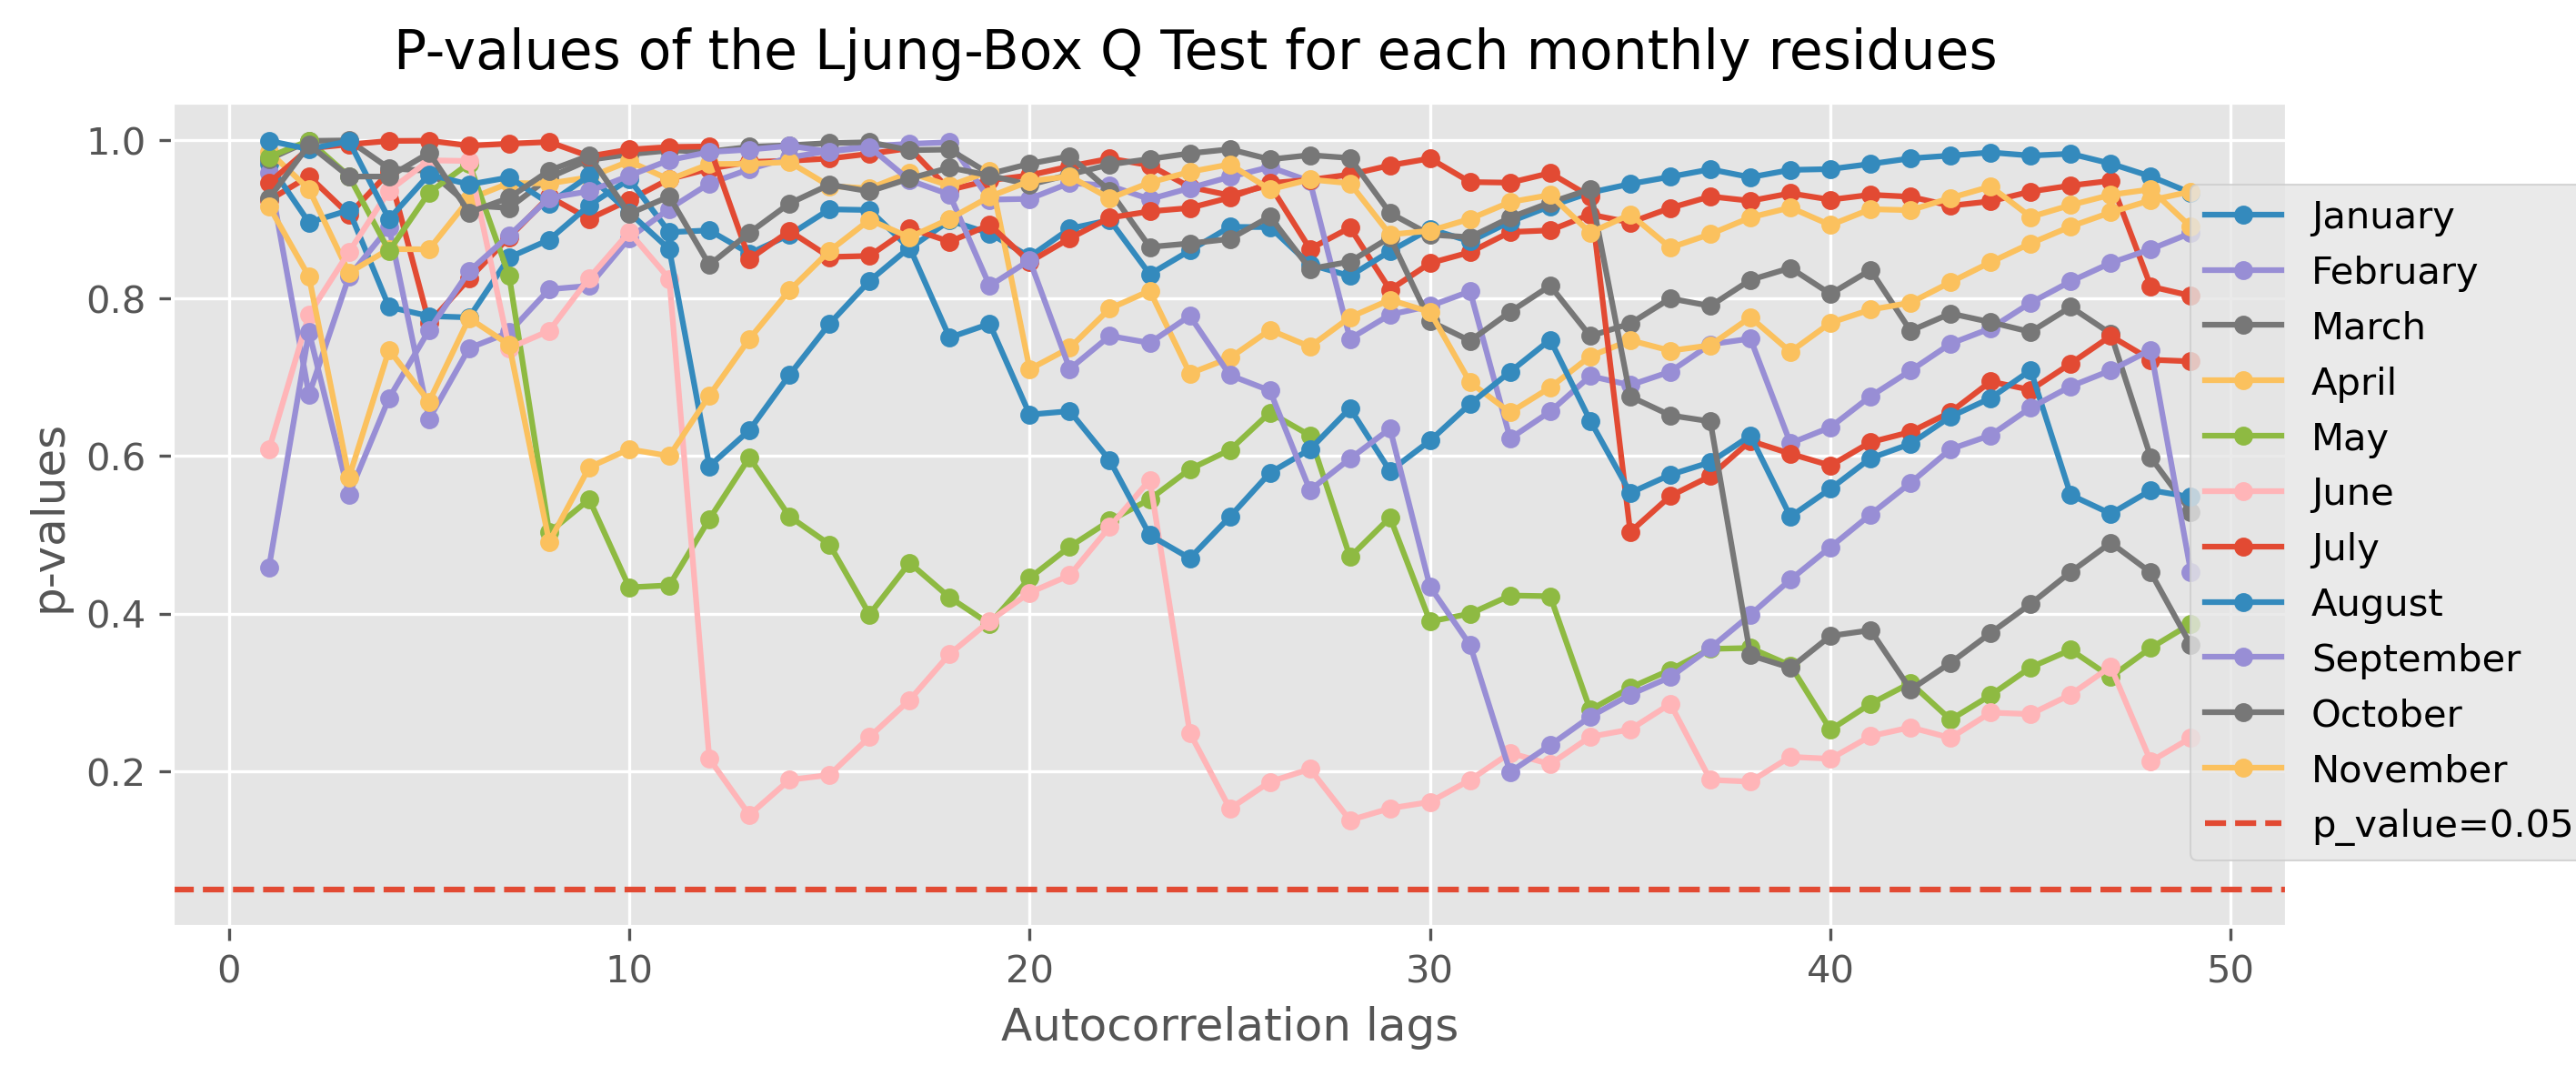

In [751]:
#Test Q de Ljung-Box

test_Q = [sm.stats.acorr_ljungbox(arma_mod[m-1].resid, lags=range(1,50), return_df=True) for m in Months]

fig = plt.figure(figsize=(10,4), dpi=300)
fig.suptitle("P-values of the Ljung-Box Q Test for each monthly residues",y = 0.95
             ,size='x-large',weight = 'roman')

for i in range(12):
    plt.plot(test_Q[i].lb_pvalue,'-o',markersize = 4,label=calendar.month_name[i])

#plt.semilogy()
plt.axhline(y=0.05,linestyle='--',label='p_value='+str(0.05))
fig.legend(loc = (0.85,0.2))
plt.xlabel('Autocorrelation lags')
plt.ylabel('p-values')

plt.savefig("figure/Monthly/p_values_Ljung_Test_detrended_mean_ARMA2_2.png", dpi=300, bbox_inches='tight')
#plt.close(fig)

In [752]:
norm_test = [sc.stats.jarque_bera(arma_mod[m-1].resid).pvalue for m in Months]

fig = plt.figure(figsize=(10,4), dpi=300)
fig.suptitle("P-values of the normal test on the ",y = 0.95
             ,size='x-large',weight = 'roman')

for i in range(12):
    plt.plot(test_Q[i].lb_pvalue,'-o',markersize = 4,label=calendar.month_name[i])

#plt.semilogy()
plt.axhline(y=0.05,linestyle='--',label='p_value='+str(0.05))
fig.legend(loc = (0.85,0.2))
plt.xlabel('Autocorrelation lags')
plt.ylabel('p-values')

plt.savefig("figure/Monthly/p_values_Ljung_Test_detrended_mean_ARMA2_2.png", dpi=300, bbox_inches='tight')
#plt.close(fig)

[ True False  True  True  True False  True  True  True  True  True  True]
[ True False  True  True  True False  True  True  True False  True  True]


In [728]:
model = [np.unravel_index(np.argmin(model_selection[m], axis=None), model_selection[m].shape) for m in range(12)]

In [729]:
arma_mod = [ARIMA(data_M[data_M.Month == float(m+1)].Monthly_Detrended_Mean, 
                  order=(model[m-1][0],0,model[m-1][1])).fit(method = 'innovations_mle') for m in range(12)]

/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/kieranvaudaux/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported inde

In [753]:
#Test Q de Ljung-Box

test_Q = [sm.stats.acorr_ljungbox(arma_mod[m-1].resid, lags=range(1,50), return_df=True) for m in Months]

fig = plt.figure(figsize=(10,4), dpi=300)
fig.suptitle("P-values of the Ljung-Box Q Test for each monthly residues",y = 0.95
             ,size='x-large',weight = 'roman')

for i in range(12):
    plt.plot(test_Q[i].lb_pvalue,'-o',markersize = 4,label=calendar.month_name[i])

#plt.semilogy()
plt.axhline(y=0.05,linestyle='--',label='p_value='+str(0.05))
fig.legend(loc = (0.85,0.2))
plt.xlabel('Autocorrelation lags')
plt.ylabel('p-values')

plt.savefig("figure/Monthly/p_values_Ljung_Test_detrended_mean_ARMA_by_month.png", dpi=300, bbox_inches='tight')
plt.close(fig)

In [749]:
norm_test = [sc.stats.jarque_bera(arma_mod[m-1].resid).pvalue for m in Months]
print(np.array(norm_test)>0.05)
norm_test = [sc.stats.jarque_bera(data_M[data_M.Month == float(m)].Monthly_Detrended_Mean).pvalue for m in Months]
print(np.array(norm_test)>0.05)

[ True False  True  True  True False  True  True  True  True  True  True]
[ True False  True  True  True False  True  True  True False  True  True]


(array([ 2.,  1.,  1.,  0.,  4.,  7.,  4., 10.,  9.,  4.,  5., 10.,  5.,
         6.,  7.,  6.,  7.,  5.,  4.,  2.,  5.,  3.,  1.,  5.,  1.,  2.,
         3.,  1.,  0.,  1.]),
 array([-3.25711719, -3.01483762, -2.77255805, -2.53027848, -2.28799891,
        -2.04571934, -1.80343977, -1.5611602 , -1.31888063, -1.07660106,
        -0.83432149, -0.59204192, -0.34976236, -0.10748279,  0.13479678,
         0.37707635,  0.61935592,  0.86163549,  1.10391506,  1.34619463,
         1.5884742 ,  1.83075377,  2.07303334,  2.31531291,  2.55759248,
         2.79987205,  3.04215162,  3.28443119,  3.52671076,  3.76899033,
         4.0112699 ]),
 <BarContainer object of 30 artists>)

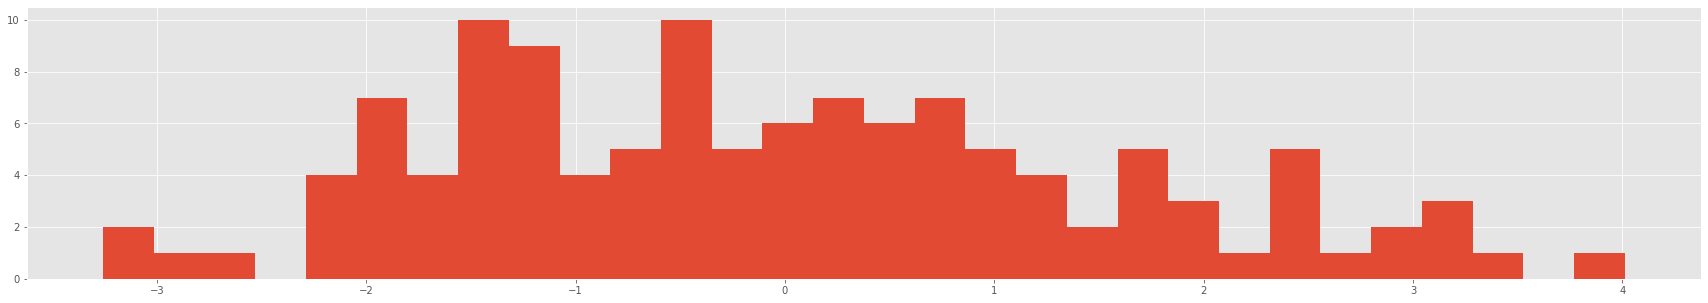

In [744]:
plt.figure(figsize=(30,5))
plt.hist(arma_mod[6].resid,bins = 30)

In [ ]:
class plot_fct():
    def __init__(self, dat):
        self.dat = dat
    
    def pl(self):
        plt.figure(figsize=(20,5))
        plt.plot(self.dat)